# Using fastai for the RANZCR CLiP - Catheter and Line Position Challenge

In this notebook, I had a look how easily one can adapt code from the Cassava leaf disease classification challenge to this one. This is heavily borrowing from Zach Mueller's work, where he shared a [fastai notebook](https://www.kaggle.com/muellerzr/recreating-abhishek-s-tez-with-fastai) that implemented [ideas of Abishek Thakur](https://www.kaggle.com/abhishek/tez-faster-and-easier-training-for-leaf-detection?scriptVersionId=47408263) and his [tez package](https://github.com/abhishekkrthakur/tez) in fastai.

Right off the bat, this notebook trains a model that then gave me a LB score of 0.945.

Here I'm showing how to adapt that code, in particular how to set-up the target. As my back-bone pre-trained model, I use EfficientNet-B4. Since we install the `efficientnet-pytorch` package I download the pre-trained weights, we leave the internet on in this notebook, but then leave it off in the inference notebook we use for submission.

In [1]:
!pip install efficientnet-pytorch -qqq

# Image augmentation

The first thing to do, is to set up augmentations. I use albumentations for that. Looking at the images (see some examples further on in the notbook), I had the impression that I would not want to use augmentations that did not show most of the upper torso. That's why I picked `albumentations.RandomResizedCrop(380,380, scale=(0.85, 1.0))` (i.e. I keep 85 to 100% of the original image). I also limited the amount of rotation to what I saw happening naturally in the images, and kept some coarse dropout + cutout. Clearly, this needs a lot more experimentation.

In [2]:
from fastai.vision.all import *
import albumentations # Data Augmentation
from efficientnet_pytorch import EfficientNet # The Model

class AlbumentationsTransform(DisplayedTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
    
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)    
    
def get_train_aug(): return albumentations.Compose([            
            albumentations.RandomResizedCrop(380,380, scale=(0.85, 1.0)),
            albumentations.ShiftScaleRotate(shift_limit=0.025, scale_limit=0.1, rotate_limit=10, p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])    
    
def get_valid_aug(): return albumentations.Compose([
    albumentations.Resize(385,385),
    albumentations.CenterCrop(380,380, p=1.)    
], p=1.)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())

# Setting up the data block

This is what took me the longest to adapt. Now that I see the syntax, it seems straightforward enough, but it took me a while to realize that I had to use `encoded=True` and `vocab` in the `MultiCategoryBlock`. As you can see, there's no proper cross-validation here, which is of course something you'd want to add. Setting this up helped me understand better what each bit does:
* `blocks`: Defining what data we are reading in and what it means. Here's it's images and tabular data indicating multi-label labels that are to be encoded with the names of the targets in this competition.
* `splitter`: splits into training and validation data
* `get_x` and `get_y`: these get the inputs and outputs. The `ColReader` function is a pretty convenient utility function for setting this up.
* Finally, we specify transformations (i.e. augmentations).

In [3]:
set_seed(538)

path = Path("../input")
data_path = path/'ranzcr-clip-catheter-line-classification'
df = pd.read_csv(data_path/'train.csv')
blocks = (ImageBlock, MultiCategoryBlock)
splitter = RandomSplitter(valid_pct=0.2, seed=999)


block = DataBlock(blocks=(ImageBlock, 
                          MultiCategoryBlock(encoded=True, vocab=['ETT - Abnormal', 'ETT - Borderline','ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
                                     'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
                                     'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present'])),                   
                   splitter=splitter,
                   get_x=ColReader(0, pref='../input/ranzcr-clip-catheter-line-classification/train/', suff='.jpg'),
                   get_y=ColReader(['ETT - Abnormal', 'ETT - Borderline','ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
                                     'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
                                     'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']),
                   item_tfms=item_tfms,
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)])



Here is how data gets loaded. As we can see our augmentations did not fundamentally change what the pictures look like, so this is probably the kind of augmentation that we would expect to help, but which can probably be improved upon.

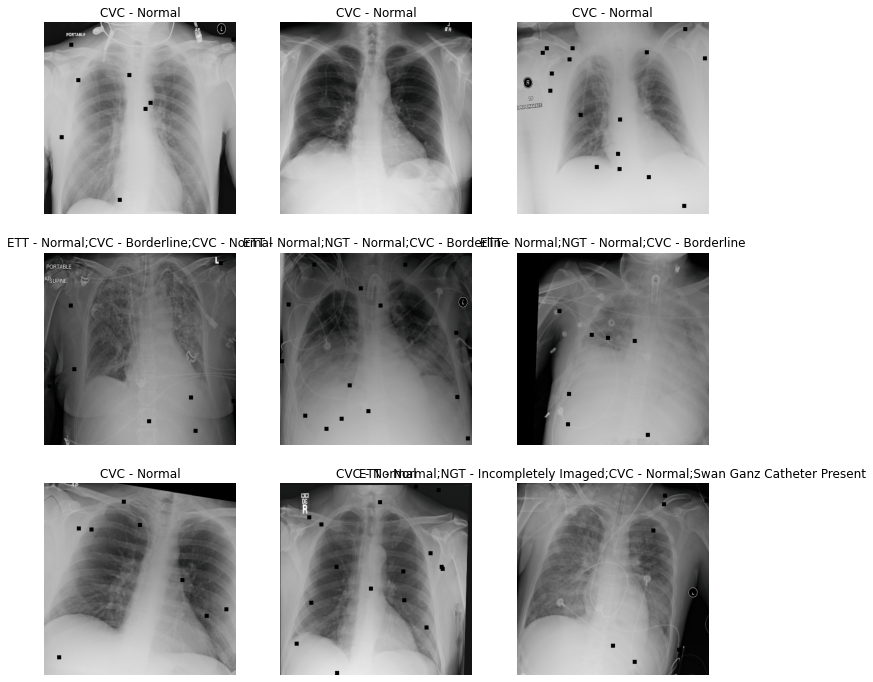

In [4]:
dls = block.dataloaders(df, bs=32, val_bs=64)
dls.show_batch(figsize=(12,12))

# Setting up a model

Now we define a PyTorch model, without doing anything very fancy. We're going from a pre-trained EfficientNet-B4 to predicting for the number of classes we have.

In [5]:
class MyModel(Module):
    def __init__(self, num_classes):

        self.effnet = EfficientNet.from_pretrained("efficientnet-b5")
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(1792, num_classes)

    def forward(self, image):
        batch_size, _, _, _ = image.shape

        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        outputs = self.out(self.dropout(x))
        return outputs


Since we set up the dataloader properly, it knows the number of classes (11).

In [6]:
net = MyModel(dls.c)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


We setup a fastai learner. I use mixed precision (fp16). As a loss function, I'm using binary cross-entroy loss on each target, but given the class imbalance, one might imagine that something else like label smoothing or focal loss might be worth trying. I monitored accuracy here, but really should also monitor the ROC.

In [7]:
learn = Learner(dls, 
                net, 
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[accuracy_multi]).to_native_fp16()


# Training the model
Now we pick a maximum learning rate and then train using [cosine annealing with warm restarts](https://paperswithcode.com/paper/sgdr-stochastic-gradient-descent-with-warm). There's plenty of other things to try here like fine tuning after initially freezing the backbone, or e.g. freezing the batchnorm layers. 

Finally, we same the trained model so we can use it in another notebook.

In [8]:
lr_min, lr_steep = learn.lr_find()
print(f'steep: {lr_steep}, min: {lr_min}')
print( (lr_min+lr_steep)/2 )


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [9]:
learn.fit_flat_cos(10, 3e-3, pct_start=0.0) # We could also do things like: cbs=[EarlyStoppingCallback(patience=3),SaveModelCallback()])

RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 15.90 GiB total capacity; 14.95 GiB already allocated; 69.75 MiB free; 15.08 GiB reserved in total by PyTorch)

In [10]:
learn.export('baseline-b5')